In [20]:
import h5py
import numpy as np
import os
import torch

# from tensorflow.keras.layers import Input,Reshape,ZeroPadding2D,MaxPool2D,Conv1D,Conv2D,Dropout,Flatten,Dense,Activation,MaxPooling2D,AlphaDropout
# from tensorflow.keras import layers
# import tensorflow.keras.models as Model
# from tensorflow.keras.regularizers import *
# from tensorflow.keras.optimizers import Adam
# import seaborn as sns
# import tensorflow as tf
# import matplotlib.pyplot as plt
# from tensorflow.keras.models import load_model
# import gc

In [69]:
raw_data = h5py.File('../ExtractDataset/part0.h5')
sample_size = raw_data['X'].shape[0]
sample_split = int(sample_size*0.8)
idx = np.random.permutation(sample_size)
train_idx, test_idx = idx[:sample_split], idx[sample_split:]
X_train = np.array(raw_data['X'][:][train_idx])
Y_train = np.argmax(np.array(raw_data['Y'][:][train_idx]), axis=1)
Z_train = np.array(raw_data['Z'][:][train_idx])
print(X_train.shape)
print(Y_train.shape)
print(Z_train.shape)
X_test = np.array(raw_data['X'][:][test_idx])
Y_test = np.argmax(np.array(raw_data['Y'][:][test_idx]), axis=1)
Z_test = np.array(raw_data['Z'][:][test_idx])
print(X_test.shape)
print(Y_test.shape)
print(Z_test.shape)
raw_data.close()

for i in range(1,12):
    filename = '../ExtractDataset/part'+str(i) + '.h5'
    print(filename)
    raw_data = h5py.File(filename,'r')
    sample_size = raw_data['X'].shape[0]
    sample_split = int(sample_size*0.8)
    idx = np.random.permutation(sample_size)
    train_idx, test_idx = idx[:sample_split], idx[sample_split:]
    X_train = np.vstack((X_train, np.array(raw_data['X'][:][train_idx])))
    Y_train = np.hstack((Y_train, np.argmax(np.array(raw_data['Y'][:][train_idx]), axis=1)))
    Z_train = np.vstack((Z_train, np.array(raw_data['Z'][:][train_idx])))
    X_test = np.vstack((X_test, np.array(raw_data['X'][:][test_idx])))
    Y_test = np.hstack((Y_test, np.argmax(np.array(raw_data['Y'][:][test_idx]), axis=1)))
    Z_test = np.vstack((Z_test, np.array(raw_data['Z'][:][test_idx])))
    raw_data.close()

(24960, 1024, 2)
(24960,)
(24960, 1)
(6240, 1024, 2)
(6240,)
(6240, 1)
../ExtractDataset/part1.h5
../ExtractDataset/part2.h5
../ExtractDataset/part3.h5
../ExtractDataset/part4.h5
../ExtractDataset/part5.h5
../ExtractDataset/part6.h5
../ExtractDataset/part7.h5
../ExtractDataset/part8.h5
../ExtractDataset/part9.h5
../ExtractDataset/part10.h5
../ExtractDataset/part11.h5


ValueError: cannot reshape array of size 613416960 into shape (24960,1,1024,2)

In [74]:

X_train = X_train.reshape((X_train.shape[0], 1, 1024, 2))
X_test = X_test.reshape((X_test.shape[0], 1, 1024, 2))
print('X_train-size：',X_train.shape)
print('Y_train-size：',Y_train.shape)
print('Z_train-size：',Z_train.shape)
print('X_test-size：',X_test.shape)
print('Y_test-size：',Y_test.shape)
print('Z_test-size：',Z_test.shape)

X_train-size： (299520, 1, 1024, 2)
Y_train-size： (299520,)
Z_train-size： (299520, 1)
X_test-size： (74880, 1, 1024, 2)
Y_test-size： (74880,)
Z_test-size： (74880, 1)


In [75]:
from torch.utils.data import TensorDataset, DataLoader
training_set = TensorDataset(torch.Tensor(X_train), torch.Tensor(Y_train))
train_dataloader = DataLoader(training_set, batch_size=16, shuffle=True)
testing_set = TensorDataset(torch.Tensor(X_test), torch.Tensor(Y_test))
test_dataloader = DataLoader(testing_set, batch_size=16, shuffle=False)

In [82]:
from torch import nn
from torch.nn import functional as F

classes = ['32PSK',
 '16APSK',
 '32QAM',
 'FM',
 'GMSK',
 '32APSK',
 'OQPSK',
 '8ASK',
 'BPSK',
 '8PSK',
 'AM-SSB-SC',
 '4ASK',
 '16PSK',
 '64APSK',
 '128QAM',
 '128APSK',
 'AM-DSB-SC',
 'AM-SSB-WC',
 '64QAM',
 'QPSK',
 '256QAM',
 'AM-DSB-WC',
 'OOK',
 '16QAM']


class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv0 = nn.Conv2d(1, 16, kernel_size=(3, 2), padding=(1, 0))
        self.bn0 = nn.BatchNorm2d(16)
        self.fc1 = nn.Linear(16384, 24)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.conv0(x)
        x = self.bn0(x)
        x = torch.flatten(x, 1)
        x = self.relu(self.fc1(x))
        return x

net = Net()

In [83]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.01, momentum=0.9)

In [84]:
global_loss = []
global_accu = []
num_epochs = 50
import time

ts = time.time()
for epoch in range(num_epochs):  # loop over the dataset multiple times

    running_loss = 0.0
    correct = 0
    total = 0
    for i, data in enumerate(train_dataloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        labels = labels.type(torch.long)
#         print(inputs, labels, outputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
#         print(inputs, labels, predicted)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        
    global_loss.append(running_loss)
    global_accu.append(100 * correct / total)
    print('[Epoch %d] loss: %f' %
          (epoch + 1, running_loss))
    print('Accuracy of the network: %f %%' % (
        100 * correct / total))

tt = time.time()
print('Finished Training, elapsed %.3f seconds'%(tt-ts))

[Epoch 1] loss: 59528.982205
Accuracy of the network: 8.339009 %
[Epoch 2] loss: 59493.177109
Accuracy of the network: 8.333333 %
[Epoch 3] loss: 59493.220490
Accuracy of the network: 8.333667 %
[Epoch 4] loss: 59493.177109
Accuracy of the network: 8.333333 %
[Epoch 5] loss: 59493.177109
Accuracy of the network: 8.333333 %
[Epoch 6] loss: 59493.177109
Accuracy of the network: 8.333333 %
[Epoch 7] loss: 59493.177109
Accuracy of the network: 8.333333 %
[Epoch 8] loss: 59493.924909
Accuracy of the network: 8.333333 %
[Epoch 9] loss: 59492.978493
Accuracy of the network: 8.333667 %
[Epoch 10] loss: 59492.978571
Accuracy of the network: 8.333667 %
[Epoch 11] loss: 59493.177109
Accuracy of the network: 8.333333 %
[Epoch 12] loss: 59493.003484
Accuracy of the network: 8.333667 %
[Epoch 13] loss: 59492.978481
Accuracy of the network: 8.333667 %
[Epoch 14] loss: 59492.978480
Accuracy of the network: 8.333667 %
[Epoch 15] loss: 59492.978480
Accuracy of the network: 8.333667 %
[Epoch 16] loss: 59

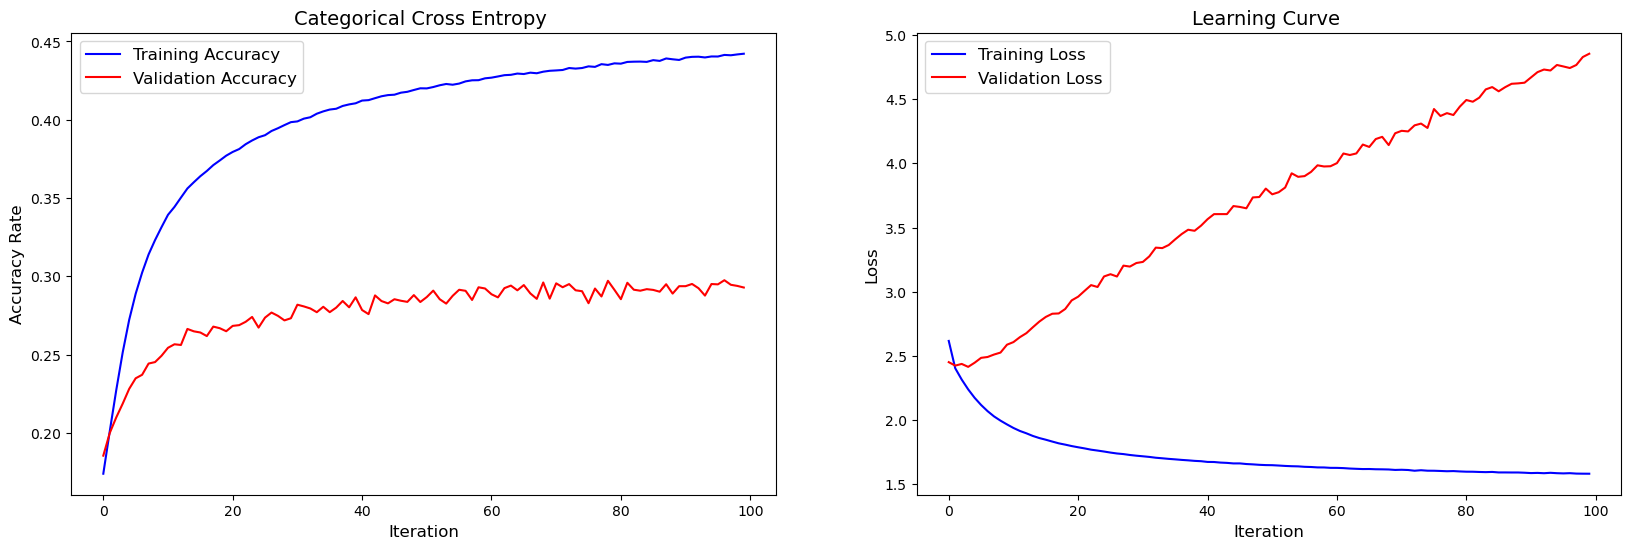

In [10]:
fig, ((ax1, ax2)) = plt.subplots(nrows=1, ncols=2,figsize=(20,6))

ax1.plot(history.history['accuracy'],'b', history.history['val_accuracy'], 'r')
ax1.set_ylabel('Accuracy Rate',fontsize=12)
ax1.set_xlabel('Iteration',fontsize=12)
ax1.set_title('Categorical Cross Entropy ',fontsize=14)
ax1.legend(['Training Accuracy','Validation Accuracy'],fontsize=12,loc='best')

ax2.plot(history.history['loss'], 'b',history.history['val_loss'],'r')
ax2.set_ylabel('Loss',fontsize=12)
ax2.set_xlabel('Iteration',fontsize=12)
ax2.set_title('Learning Curve ',fontsize=14)
ax2.legend(['Training Loss','Validation Loss'],fontsize=12,loc='best')

# plt.savefig('crosse_results.png')
plt.show()

In [11]:
model = load_model(filepath)

In [12]:
def plot_confusion_matrix(cm, title='Confusion matrix', cmap=plt.cm.Blues, labels=[]):
    plt.figure(figsize=(10, 10))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(labels))
    plt.xticks(tick_marks, labels, rotation=45)
    plt.yticks(tick_marks, labels)
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
# Plot confusion matrix
batch_size = 1024
test_Y_hat = model.predict(X_test, batch_size=3000)
conf = np.zeros([len(classes),len(classes)])
confnorm = np.zeros([len(classes),len(classes)])
for i in range(0,X_test.shape[0]):
    j = list(Y_test[i,:]).index(1)
    k = int(np.argmax(test_Y_hat[i,:]))
    conf[j,k] = conf[j,k] + 1
for i in range(0,len(classes)):
    confnorm[i,:] = conf[i,:] / np.sum(conf[i,:])
plot_confusion_matrix(confnorm, labels=classes)

In [13]:
for i in range(len(confnorm)):
    print(classes[i],confnorm[i,i])

32PSK 0.7204884667571235
16APSK 0.13236521448839927
32QAM 0.6049543676662321
FM 0.1187648456057007
GMSK 0.06044047027653585
32APSK 0.013129821106187428
OQPSK 0.09319286871961102
8ASK 0.03505224132119986
BPSK 0.04079585353619796
8PSK 0.10101867572156197
AM-SSB-SC 0.10810810810810811
4ASK 0.03361344537815126
16PSK 0.011577902745616937
64APSK 0.060565944067516135
128QAM 0.10415978870914493
128APSK 0.3849199802012869
AM-DSB-SC 0.03420222480491449
AM-SSB-WC 0.14427350427350427
64QAM 0.662512630515325
QPSK 0.09209398044932258
256QAM 0.8110584001308686
AM-DSB-WC 0.8397762789932555
OOK 0.0310246520207949
16QAM 0.04854695111708383


In [15]:

acc={}
Z_test = Z[test_idx]
Z_test = Z_test.reshape((len(Z_test)))
SNRs = np.unique(Z_test)
for snr in SNRs:
    X_test_snr = X_test[Z_test==snr]
    Y_test_snr = Y_test[Z_test==snr]
    
    pre_Y_test = model.predict(X_test_snr)
    conf = np.zeros([len(classes),len(classes)])
    confnorm = np.zeros([len(classes),len(classes)])
    for i in range(0,X_test_snr.shape[0]):    #该信噪比下测试数据量
        j = list(Y_test_snr[i,:]).index(1)   #正确类别下标
        k = int(np.argmax(pre_Y_test[i,:])) #预测类别下标
        conf[j,k] = conf[j,k] + 1
    for i in range(0,len(classes)):
        confnorm[i,:] = conf[i,:] / np.sum(conf[i,:])
   
    plt.figure()
    plot_confusion_matrix(confnorm, labels=classes, title="ConvNet Confusion Matrix (SNR=%d)"%(snr))
    
    cor = np.sum(np.diag(conf))
    ncor = np.sum(conf) - cor
    print ("Overall Accuracy %s: "%snr, cor / (cor+ncor))
    acc[snr] = 1.0*cor/(cor+ncor)

Overall Accuracy -20:  0.1476906552094522
Overall Accuracy -18:  0.15249320036264732
Overall Accuracy -16:  0.15970425138632163
Overall Accuracy -14:  0.16714095996964523
Overall Accuracy -12:  0.16576770945702984
Overall Accuracy -10:  0.17173278378842521
Overall Accuracy -8:  0.20173574211831385
Overall Accuracy -6:  0.20066273932253315
Overall Accuracy -4:  0.21202185792349726


<ipython-input-12-eeb1cbd8bdb2>:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(figsize=(10, 10))


Overall Accuracy -2:  0.21637426900584794
Overall Accuracy 0:  0.21590093323761667
Overall Accuracy 2:  0.23325380803817214
Overall Accuracy 4:  0.2466412340354951
Overall Accuracy 6:  0.25311203319502074
Overall Accuracy 8:  0.2591387559808612
Overall Accuracy 10:  0.23992963940193493
Overall Accuracy 12:  0.25649819494584836
Overall Accuracy 14:  0.24350826221173053
Overall Accuracy 16:  0.2513723263297369
Overall Accuracy 18:  0.24284140969162996
Overall Accuracy 20:  0.25367270242569184
Overall Accuracy 22:  0.25760909424275763
Overall Accuracy 24:  0.24791742122419413
Overall Accuracy 26:  0.25114800423878486
Overall Accuracy 28:  0.25305601167670133
Overall Accuracy 30:  0.2466467958271237


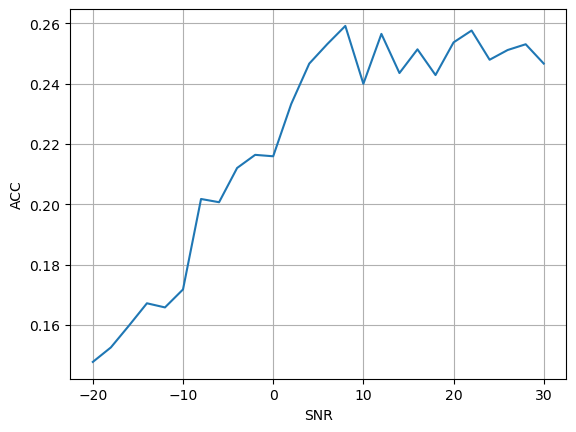

In [17]:

plt.plot(acc.keys(),acc.values())
plt.ylabel('ACC')
plt.xlabel('SNR')
plt.grid(True)
plt.show()